### Dependencies and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install -U sentence-transformers
!pip install -U transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.6 MB/s 
     |████████████████████████████████| 182 kB 76.9 MB/s 
     |████████████████████████████████| 7.6 MB 58.0 MB/s 


In [3]:
import os
import torch
from torch import nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel

import pandas as pd
import numpy as np
import tqdm, glob

from torch.utils.data import Dataset, DataLoader
from torchvision.models.feature_extraction import create_feature_extractor

import random


In [4]:
%cd /content/drive/MyDrive/multi-modal-music-genre-classification/
from CNN import CNN
# from utils import load_data

/content/drive/.shortcut-targets-by-id/199GHGZBtQOuthTQ8c7i5neHpvqm7epIw/multi-modal-music-genre-classification


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Lyric Module

In [ ]:
class LyricModule(nn.Module):
  def __init__(self, pretrained_lyric_model): #, max_seq_len):
    super(LyricModule, self).__init__()

    # # Pretrained lyric model to get lyric embeddings
    self.pretrained = pretrained_lyric_model
    # print("Max Sequence Length:", self.pretrained.max_seq_length)
    # self.pretrained.max_seq_length = max_seq_len # common for BERT and its derivatives
    # print("Max Sequence Length:", self.pretrained.max_seq_length)

    # self.lyric_dim = self.pretrained.get_sentence_embedding_dimension()
    self.embedding_dim = 768

  def forward(self, input_ids, attention_mask):
    '''
    input_ids: shape (batch_size, num_tokens)
    attention_mask: shape (batch_size, num_tokens)

    embeddings: shape (batch_size, num_tokens, embedding_dim)
    pooled: shape (batch_size, embedding_dim)
    '''
    # embeddings = self.pretrained.encode(lyrics, convert_to_tensor=True).to(device)
    bert_output = self.pretrained(input_ids = input_ids, attention_mask = attention_mask)
    embeddings = bert_output.last_hidden_state
    pooled = bert_output.pooler_output

    return embeddings, pooled

### Genre Classifier Module

In [ ]:
class GenreClassifier(nn.Module):
    def __init__(
        self,
        spectrogram_model,
        lyric_model,
        cma_model,
        num_classes
        ):
        super(GenreClassifier, self).__init__()

        self.lyric_model = lyric_model
        self.spectrogram_model = spectrogram_model
        # self.cma_model = cma_model

        self.num_classes = num_classes

        # FC layers after CMA
        # self.linear = nn.Linear(self.cma_model.embedding_size, self.num_classes)

        self.lyric_linear_layers = nn.Sequential(
            nn.Linear(self.lyric_model.embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            # nn.Linear(64, self.num_classes)
            )
        self.cnn_linear_layers = nn.Sequential(
            nn.ReLU(),
            # nn.Linear(64, self.num_classes)
        )
        self.concat_linear_layers = nn.Sequential(
            nn.Linear(64+64, self.num_classes)
        )

    def forward(self, input_ids, attention_mask, spectrograms):
      '''
      input_ids: shape (batch_size, num_tokens)
      attention_mask: shape (batch_size, num_tokens)
      spectrograms: shape (batch_size, ??)
      '''
      #### get embeddings 
      token_embeddings, pooled = self.lyric_model(input_ids, attention_mask)
      spectrogram_embeddings = self.spectrogram_model(spectrograms.float())['linear1']

      #### linear layers

      output = torch.cat((self.cnn_linear_layers(spectrogram_embeddings), self.lyric_linear_layers(pooled)), 1)
      output = self.concat_linear_layers(output)
      return output 

      # output = self.cma(lyric_embeddings, spectrogram_embeddings)

      #TODO: add linear layers 
      # output = self.linear(output)

      # return output

## Training

### Load data

In [ ]:
BATCH_SIZE = 64

In [ ]:
# pretrained_lyric_model = SentenceTransformer('all-mpnet-base-v2')
# pretrained_lyric_model.get_sentence_embedding_dimension()
pretrained_lyric_model = BertModel.from_pretrained('bert-base-uncased')
pretrained_lyric_model.eval()
# FREEZE BERT MODEL
for param in pretrained_lyric_model.parameters():
  param.requires_grad = False

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
genre_list = np.load("genre_list.npy")
# zipped_data, genre_list = load_data()
NUM_CLASSES = len(genre_list)
print(NUM_CLASSES)
print(genre_list)

5
['Pop' 'Rock' 'Gospel/Religious' 'Indie' 'Heavy Metal']


In [ ]:
# custom data loader

class CustomDataset(Dataset):
    def __init__(self,split):
        print("Creating custom dataset ...")

        self.specs_path = f"{split}_specs.npy"
        self.tokens_path = f"{split}_tokens.npy"
        self.attention_mask_path = f"{split}_attention_masks.npy"
        self.y_path = f"{split}_y.npy"


        # # self.input, self.target = zip(*split)
        # # self.melspec, self.lyrics = zip(*self.input)

        self.melspec = torch.unsqueeze(torch.tensor(np.stack(np.load(self.specs_path, allow_pickle=True))), 1)
        self.tokens = torch.tensor(np.load(self.tokens_path))
        self.attention_mask = torch.tensor(np.load(self.attention_mask_path))
        self.target = torch.tensor(np.load(self.y_path))
        # #### reshape spectrograms
        # self.melspec = torch.from_numpy(np.array([x.reshape( (1, 128, 431) ) for x in self.melspec]))
        print("melspec shape:", self.melspec.shape)

        # #### tokenize lyrics
        # # self.lyrics = list(self.lyrics)
        # # tokenizer_output = tokenizer(self.lyrics, padding=True, truncation=True, return_tensors="pt")
        # # self.input_ids = tokenizer_output['input_ids']
        # # self.attention_mask = tokenizer_output['attention_mask']
        print("tokens shape:", self.tokens.shape)
        print("attention mask shape:", self.attention_mask.shape)
        print("target shape:", self.target.shape)

        # self.target = torch.tensor(target)
        # print("-------------------")


        
    def __getitem__(self, index):
        
        # #melspec, lyric data-pair

        data_pair = (self.melspec[index], (self.tokens[index], self.attention_mask[index]))
        label = self.target[index]
        return data_pair, label



    def __len__(self):
        count = len(self.target)
        return count 

In [ ]:
#### data separation 
# dataset = zipped_data
# random.shuffle(dataset)
# del(dataset)

# trainDataset = CustomDataset(train, tokenizer, pretrained_lyric_model)
# del(train)
# valDataset = CustomDataset(val, tokenizer, pretrained_lyric_model)
# del(val)
# testDataset = CustomDataset(test, tokenizer, pretrained_lyric_model)
# del(test)

# del(pretrained_lyric_model)
# del(tokenizer)
# trainDataset = CustomDataset("train")
# valDataset = CustomDataset("val")
testDataset = CustomDataset("test")
# del(specs)
# del(tokens)
# del(attention_mask)

# trainLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE)
# valLoader = DataLoader(valDataset, batch_size=BATCH_SIZE)
testLoader = DataLoader(testDataset)


Creating custom dataset ...
melspec shape: torch.Size([863, 1, 128, 431])
tokens shape: torch.Size([863, 512])
attention mask shape: torch.Size([863, 512])
target shape: torch.Size([863])


In [ ]:
# del(trainDataset)
# del(valDataset)
del(testDataset)
# del(zipped_data)
# del(trainLoader)
# del(testLoader)
# del(valLoader)
# del(model)

In [ ]:
import gc
gc.collect()

51

### Define model

In [ ]:
pretrained_cnn_model = CNN(num_classes = NUM_CLASSES).to(device)
pretrained_cnn_model.load_state_dict(torch.load('CNN_pytorch_training/saved_model.pth'))

<All keys matched successfully>

In [ ]:
lyric_model = LyricModule(pretrained_lyric_model)

spectrogram_model = create_feature_extractor(pretrained_cnn_model, return_nodes=['linear1'])

# FREEZE CNN MODEL
for param in spectrogram_model.parameters():
  param.requires_grad = False 

cma_model = None

model = GenreClassifier(spectrogram_model, lyric_model, cma_model, NUM_CLASSES).float().to(device)

In [ ]:
for param in model.named_parameters():
  print(param[0], param[1][1].requires_grad)

lyric_model.pretrained.embeddings.word_embeddings.weight False
lyric_model.pretrained.embeddings.position_embeddings.weight False
lyric_model.pretrained.embeddings.token_type_embeddings.weight False
lyric_model.pretrained.embeddings.LayerNorm.weight False
lyric_model.pretrained.embeddings.LayerNorm.bias False
lyric_model.pretrained.encoder.layer.0.attention.self.query.weight False
lyric_model.pretrained.encoder.layer.0.attention.self.query.bias False
lyric_model.pretrained.encoder.layer.0.attention.self.key.weight False
lyric_model.pretrained.encoder.layer.0.attention.self.key.bias False
lyric_model.pretrained.encoder.layer.0.attention.self.value.weight False
lyric_model.pretrained.encoder.layer.0.attention.self.value.bias False
lyric_model.pretrained.encoder.layer.0.attention.output.dense.weight False
lyric_model.pretrained.encoder.layer.0.attention.output.dense.bias False
lyric_model.pretrained.encoder.layer.0.attention.output.LayerNorm.weight False
lyric_model.pretrained.encoder.lay

### Hyperparameters

In [ ]:
learning_rate = 1e-3
epochs = 10

### Loss function

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training Loop

In [ ]:
import tqdm

In [ ]:
# iterate through all the epochs
for epoch in range(epochs):
    # go through all the batches generated by dataloader

    ############## train loop
    train_loss = 0.0
    for i, (X, y) in tqdm.notebook.tqdm(enumerate(trainLoader)):

      specs = X[0]
      input_ids, attention_mask = X[1]
      pred = model(input_ids.to(device), attention_mask.to(device), specs.to(device))

      optimizer.zero_grad()
      # calculate loss
      loss = criterion(pred, y.to(device))
      # credit assignment
      loss.backward()
      # update model weights
      optimizer.step()

      train_loss += loss.item()
    
    ############## validation loop
    model.eval()
    valid_loss = 0.0 
    for i, (X, y) in tqdm.notebook.tqdm(enumerate(valLoader)):

      specs = X[0]
      input_ids, attention_mask = X[1]
      pred = model(input_ids.to(device), attention_mask.to(device), specs.to(device))

      # calculate loss
      loss = criterion(pred, y.to(device))
      valid_loss += loss.item() 
    

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(trainLoader)} \t\t Validation Loss: {valid_loss / len(valLoader)}')
    
    # if min_valid_loss > valid_loss:
    #     print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
    #     min_valid_loss = valid_loss
        
    #     # Saving State Dict
    # torch.save(model.state_dict(), '/content/drive/MyDrive/multi-modal-music-genre-classification/CNN_pytorch_training/saved_model.pth')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1 		 Training Loss: 1.3967794764924932 		 Validation Loss: 1.3055131435394287


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 2 		 Training Loss: 1.271894507937961 		 Validation Loss: 1.2873282517705644


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 3 		 Training Loss: 1.2250086080144953 		 Validation Loss: 1.2616658466202872


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 4 		 Training Loss: 1.2078339490625594 		 Validation Loss: 1.258801622050149


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 5 		 Training Loss: 1.1945650886606287 		 Validation Loss: 1.231644093990326


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 6 		 Training Loss: 1.18728762920256 		 Validation Loss: 1.2199358769825526


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 7 		 Training Loss: 1.172367842109115 		 Validation Loss: 1.2029163156236922


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 8 		 Training Loss: 1.161421317745138 		 Validation Loss: 1.182051066841398


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 9 		 Training Loss: 1.1469417650390554 		 Validation Loss: 1.15517116018704


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 10 		 Training Loss: 1.1344473544094298 		 Validation Loss: 1.1445931111063277


In [ ]:
############## test loop
test_loss = 0.0
total = 0.0
num_correct = 0.0

# loop over all batches in test set
for i, (X, y) in tqdm.notebook.tqdm(enumerate(testLoader)):

  specs = X[0]
  input_ids, attention_mask = X[1]
  pred = model(input_ids.to(device), attention_mask.to(device), specs.to(device))

  # pred = pretrained_cnn_model(specs.float())
  res = torch.argmax(pred, 1)

  targets = y.to(device)
  num_correct += (res.item() == targets.item())
  total += targets.size(0)
  test_loss += criterion(pred, targets).item()
    

print(f"Test Accuracy of the model: {float(num_correct)/float(total)*100:.2f}")

0it [00:00, ?it/s]

Test Accuracy of the model: 55.62


In [ ]:
%pwd

'/content/drive/.shortcut-targets-by-id/199GHGZBtQOuthTQ8c7i5neHpvqm7epIw/multi-modal-music-genre-classification'

In [ ]:
torch.save(model.state_dict(), "model_concatenation_55.pth")

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1]):
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                   zipped_data: 72.1 KiB
                         train: 53.9 KiB
                          test:  6.8 KiB
                           val:  6.8 KiB
                 BertTokenizer:  2.0 KiB
                           _i6:  1.8 KiB
                          _iii:  1.6 KiB
                           _i9:  1.6 KiB
                     BertModel:  1.4 KiB
                           CNN:  1.4 KiB
                    DataLoader:  1.0 KiB
                       Dataset:  1.0 KiB
               GenreClassifier:  1.0 KiB
                 CustomDataset:  1.0 KiB
                           _ii:  598.0 B
                          _i10:  598.0 B
                          _i12:  582.0 B
                            _i:  533.0 B
                          _i11:  533.0 B
                           _i3:  510.0 B
                           _oh:  248.0 B
                           Out:  248.0 B
                           _ih:  200.0 B
                            In:  200.0 B
                

### Concatenated Embeddings visualization

In [ ]:
# Multimodal model
classifier = GenreClassifier(spectrogram_model, lyric_model, cma_model, NUM_CLASSES).float().to(device)
classifier.load_state_dict(torch.load("model_concatenation_55.pth"))

for param in classifier.named_parameters():
  print(param[0], param[1][1].requires_grad)

lyric_model.pretrained.embeddings.word_embeddings.weight False
lyric_model.pretrained.embeddings.position_embeddings.weight False
lyric_model.pretrained.embeddings.token_type_embeddings.weight False
lyric_model.pretrained.embeddings.LayerNorm.weight False
lyric_model.pretrained.embeddings.LayerNorm.bias False
lyric_model.pretrained.encoder.layer.0.attention.self.query.weight False
lyric_model.pretrained.encoder.layer.0.attention.self.query.bias False
lyric_model.pretrained.encoder.layer.0.attention.self.key.weight False
lyric_model.pretrained.encoder.layer.0.attention.self.key.bias False
lyric_model.pretrained.encoder.layer.0.attention.self.value.weight False
lyric_model.pretrained.encoder.layer.0.attention.self.value.bias False
lyric_model.pretrained.encoder.layer.0.attention.output.dense.weight False
lyric_model.pretrained.encoder.layer.0.attention.output.dense.bias False
lyric_model.pretrained.encoder.layer.0.attention.output.LayerNorm.weight False
lyric_model.pretrained.encoder.lay

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchvision.models.feature_extraction import get_graph_node_names

In [ ]:
#classifier.eval()

# we need to use forward hooks to get the outputs from intermediate layers of the model

out = None
# Define a hook function. It sets the global out variable equal to the
# output of the layer to which this hook is attached to.

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Your model layer has a register_forward_hook that does the registering for you
# classifier = create_feature_extractor(classifier, return_nodes=['spectrogram_model.linear1'])

# classifier.lyric_model.pretrained.pooler.dense.register_forward_hook(get_activation('lyric_model.pretrained.pooler.dense'))
classifier.spectrogram_model.linear1.register_forward_hook(get_activation('spectrogram_model.linear1'))
classifier.lyric_linear_layers.register_forward_hook(get_activation('lyric_linear_layers.4'))

In [ ]:
# test_embeddings = torch.zeros((0, 64), dtype=torch.float32)
test_embeddings = torch.zeros((0, 128), dtype=torch.float32)
test_predictions = []
# loop over all batches in test set
for i, (X, y) in tqdm.notebook.tqdm(enumerate(testLoader)):

  specs = X[0]
  input_ids, attention_mask = X[1]
  pred = classifier(input_ids.to(device), attention_mask.to(device), specs.to(device))
  # bert_embeddings = activation['lyric_model.pretrained.pooler.dense']
  spec_embeddings = activation['spectrogram_model.linear1']
  lyr_embeddings = activation['lyric_linear_layers.4']
  combined_embeddings = torch.cat((spec_embeddings, lyr_embeddings), 1)
  # embeddings = pred
  res = torch.argmax(pred, 1)
  targets = y.to(device)
  test_embeddings = torch.cat((test_embeddings, combined_embeddings.detach().cpu()), 0)
  test_predictions.extend(res.detach().cpu().tolist())


test_embeddings = np.array(test_embeddings)
test_predictions = np.array(test_predictions)

0it [00:00, ?it/s]

In [ ]:
combined_embeddings

tensor([[-1.7938e-01, -1.1835e+00,  6.3446e-01,  8.8580e-01, -3.6828e-01,
         -4.5797e-01,  1.6060e-01, -9.9603e-01,  3.6635e-01,  8.8708e-01,
         -2.9146e-01,  4.4348e-01,  8.5807e-01,  4.5210e-01, -1.2690e-01,
         -4.7676e-01, -2.1067e-01, -1.1584e+00, -7.7113e-01, -4.7596e-01,
          6.3247e-01, -1.0055e+00,  2.5304e-01, -1.0891e-01, -4.9438e-01,
         -9.2694e-01,  8.7406e-02, -8.2181e-01, -4.8065e-01, -8.4127e-01,
         -7.2437e-01, -7.9019e-01, -4.8186e-02,  1.7183e+00, -2.0031e-01,
          8.0943e-02,  1.2052e+00, -6.0361e-01, -7.6111e-01, -9.2575e-02,
         -7.6642e-01, -3.0776e-01,  1.0115e-03, -5.8711e-01,  3.2518e-01,
         -5.9547e-01, -7.3096e-01,  4.5469e-01,  4.1502e-01, -8.4289e-01,
         -1.0277e-01, -4.5760e-01, -1.1548e-01,  7.4864e-02, -8.9445e-01,
          8.6994e-01, -8.0355e-01, -4.9429e-01, -5.7146e-01,  1.9383e-01,
          2.1950e-02,  1.9705e-01, -9.6845e-01, -7.9771e-01,  0.0000e+00,
          7.1512e-01,  7.7137e-01,  1.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 863 samples in 0.000s...
[t-SNE] Computed neighbors for 863 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 863 / 863
[t-SNE] Mean sigma: 0.684282
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.415066
[t-SNE] KL divergence after 1000 iterations: 0.593964


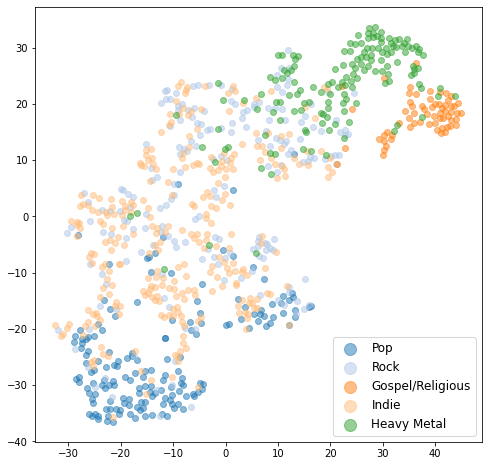

In [ ]:
# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 5
labels = ['Pop','Rock','Gospel/Religious','Indie','Heavy Metal']
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = labels[lab] ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
# ax.set_title('TSNE for Multimodal (concatenated) Embeddings ', 
#              fontweight ="bold")
plt.savefig('/content/drive/MyDrive/multi-modal-music-genre-classification/TSNE/tsne_lyr.png', bbox_inches='tight')
plt.show()


### Lyric Only Embeddings visualization

In [ ]:
class GenreClassifier(nn.Module):
    def __init__(
        self,
        spectrogram_model,
        lyric_model,
        cma_model,
        num_classes
        ):
        super(GenreClassifier, self).__init__()

        self.lyric_model = lyric_model
        self.spectrogram_model = spectrogram_model
        # self.cma_model = cma_model

        self.num_classes = num_classes

        # FC layers after CMA
        # self.linear = nn.Linear(self.cma_model.embedding_size, self.num_classes)

        self.lyric_linear_layers = nn.Sequential(
            nn.Linear(self.lyric_model.embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, self.num_classes)
            )
        self.cnn_linear_layers = nn.Sequential(
            nn.ReLU(),
            # nn.Linear(64, self.num_classes)
        )
        self.concat_linear_layers = nn.Sequential(
            nn.Linear(64+64, self.num_classes)
        )

    def forward(self, input_ids, attention_mask, spectrograms):
      '''
      input_ids: shape (batch_size, num_tokens)
      attention_mask: shape (batch_size, num_tokens)
      spectrograms: shape (batch_size, ??)
      '''
      #### get embeddings 
      token_embeddings, pooled = self.lyric_model(input_ids, attention_mask)
      # spectrogram_embeddings = self.spectrogram_model(spectrograms.float())['linear1']

      #### linear layers

      # output = torch.cat((self.cnn_linear_layers(spectrogram_embeddings), self.lyric_linear_layers(pooled)), 1)
      # output = self.concat_linear_layers(output)
      # return output 

      #### lyric module only
      output = self.lyric_linear_layers(pooled)

      # output = self.cma(lyric_embeddings, spectrogram_embeddings)

      #TODO: add linear layers 
      # output = self.linear(output)

      return output

In [ ]:
pretrained_cnn_model = CNN(num_classes = NUM_CLASSES).to(device)
pretrained_cnn_model.load_state_dict(torch.load('CNN_pytorch_training/saved_model.pth'))

lyric_model = LyricModule(pretrained_lyric_model)

spectrogram_model = create_feature_extractor(pretrained_cnn_model, return_nodes=['linear1'])

# FREEZE CNN MODEL
for param in spectrogram_model.parameters():
  param.requires_grad = False 

cma_model = None

model = GenreClassifier(spectrogram_model, lyric_model, cma_model, NUM_CLASSES).float().to(device)

for param in model.named_parameters():
  print(param[0], param[1][1].requires_grad)

lyric_model.pretrained.embeddings.word_embeddings.weight False
lyric_model.pretrained.embeddings.position_embeddings.weight False
lyric_model.pretrained.embeddings.token_type_embeddings.weight False
lyric_model.pretrained.embeddings.LayerNorm.weight False
lyric_model.pretrained.embeddings.LayerNorm.bias False
lyric_model.pretrained.encoder.layer.0.attention.self.query.weight False
lyric_model.pretrained.encoder.layer.0.attention.self.query.bias False
lyric_model.pretrained.encoder.layer.0.attention.self.key.weight False
lyric_model.pretrained.encoder.layer.0.attention.self.key.bias False
lyric_model.pretrained.encoder.layer.0.attention.self.value.weight False
lyric_model.pretrained.encoder.layer.0.attention.self.value.bias False
lyric_model.pretrained.encoder.layer.0.attention.output.dense.weight False
lyric_model.pretrained.encoder.layer.0.attention.output.dense.bias False
lyric_model.pretrained.encoder.layer.0.attention.output.LayerNorm.weight False
lyric_model.pretrained.encoder.lay

In [ ]:
classifier = GenreClassifier(spectrogram_model, lyric_model, cma_model, NUM_CLASSES).float().to(device)
classifier.load_state_dict(torch.load("model_lyric_only_43.pth"))

<All keys matched successfully>

In [ ]:
classifier.eval()

# we need to use forward hooks to get the outputs from intermediate layers of the model

out = None
# Define a hook function. It sets the global out variable equal to the
# output of the layer to which this hook is attached to.

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Your model layer has a register_forward_hook that does the registering for you

#classifier.lyric_model.pretrained.pooler.dense.register_forward_hook(get_activation('lyric_model.pretrained.pooler.dense'))
classifier.lyric_linear_layers.register_forward_hook(get_activation('lyric_linear_layers.2'))

# test_embeddings = torch.zeros((0, 64), dtype=torch.float32)
test_embeddings = torch.zeros((0, 64), dtype=torch.float32)
test_predictions = []
# loop over all batches in test set
for i, (X, y) in tqdm.notebook.tqdm(enumerate(testLoader)):

  specs = X[0]
  input_ids, attention_mask = X[1]
  pred = classifier(input_ids.to(device), attention_mask.to(device), specs.to(device))
  #bert_embeddings = activation['lyric_model.pretrained.pooler.dense']
  # spec_embeddings = activation['spectrogram_model.linear1']
  lyr_embeddings = activation['lyric_linear_layers.2']
  
  print(activation)
  break
  # combined_embeddings = torch.cat((spec_embeddings, lyr_embeddings), 1)
  res = torch.argmax(pred, 1)
  targets = y.to(device)
  test_embeddings = torch.cat((test_embeddings, lyr_embeddings.detach().cpu()), 0)
  test_predictions.extend(res.detach().cpu().tolist())

test_embeddings = np.array(test_embeddings)
test_predictions = np.array(test_predictions)

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 5
labels = ['Pop','Rock','Gospel/Religious','Indie','Heavy Metal']
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = labels[lab] ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
# ax.set_title('TSNE for Multimodal (concatenated) Embeddings ', 
#              fontweight ="bold")
plt.savefig('/content/drive/MyDrive/multi-modal-music-genre-classification/TSNE/tsne_lyricOnly43.png', bbox_inches='tight')
plt.show()

0it [00:00, ?it/s]

{'lyric_linear_layers.4': tensor([[-0.3756, -0.0110,  0.9848, -0.4731, -0.4407]], device='cuda:0'), 'lyric_linear_layers.2': tensor([[-0.3756, -0.0110,  0.9848, -0.4731, -0.4407]], device='cuda:0')}


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: ignored

### CMA Embeddings visualization

In [ ]:
import torch.nn.functional as F
from TransformerEncoder import TransformerEncoder

class CMAModule(nn.Module):
  def __init__(self, hyp_params):
    super(CMAModule, self).__init__()

    self.orig_d_l, self.orig_d_a = hyp_params['orig_d_l'], hyp_params['orig_d_a']
    self.d_l, self.d_a = 64, 64
    self.num_heads = hyp_params['num_heads']
    self.layers = hyp_params['layers']
    self.attn_dropout = hyp_params['attn_dropout']
    self.attn_dropout_a = hyp_params['attn_dropout_a']
    self.relu_dropout = hyp_params['relu_dropout']
    self.res_dropout = hyp_params['res_dropout']
    self.out_dropout = hyp_params['out_dropout']
    self.embed_dropout = hyp_params['embed_dropout']
    self.attn_mask = hyp_params['attn_mask']

    combined_dim = self.d_l + self.d_a
    output_dim = hyp_params['output_dim']

    # Init the Layers
    # 1.  Temporal Convolutional Layers
    self.proj_lyrics = nn.Conv1d(self.orig_d_l, self.d_l, kernel_size=1, padding=0, bias=False)
    self.proj_audio = nn.Conv1d(self.orig_d_a, self.d_a, kernel_size=1, padding=0, bias=False)

    # 2. CrossModal Attentions
    self.trans_l_with_a = self.get_network(self_type='la')
    self.trans_a_with_l = self.get_network(self_type='al')
    
    # 3.  Self Attentions
    self.trans_l_self = self.get_network(self_type='l_mem', layers=3)
    self.trans_a_self = self.get_network(self_type='a_mem', layers=3)

    # Projection layers???
    self.proj1 = nn.Linear(combined_dim, combined_dim)
    self.proj2 = nn.Linear(combined_dim, combined_dim)
    self.out_layer = nn.Linear(combined_dim, output_dim)
    

  def get_network(self, self_type='l', layers=-1):
      if self_type in ['l', 'al', 'vl']:
          embed_dim, attn_dropout = self.d_l, self.attn_dropout
      elif self_type in ['a', 'la', 'va']:
          embed_dim, attn_dropout = self.d_a, self.attn_dropout_a
      elif self_type == 'l_mem':
          embed_dim, attn_dropout = 1*self.d_l, self.attn_dropout
      elif self_type == 'a_mem':
          embed_dim, attn_dropout = 1*self.d_a, self.attn_dropout
      else:
          raise ValueError("Unknown network type")
      
      return TransformerEncoder(embed_dim=embed_dim,
                                num_heads=self.num_heads,
                                layers=max(self.layers, layers),
                                attn_dropout=attn_dropout,
                                relu_dropout=self.relu_dropout,
                                res_dropout=self.res_dropout,
                                embed_dropout=self.embed_dropout,
                                attn_mask=self.attn_mask)
      
    

  def forward(self, x_l, x_a):
    # x_l : lyrics
    # x_a : audio

    # Using 1D Convolution Layer
    x_l = x_l.transpose(1, 2)
    x_a = x_a.transpose(1, 2)
    proj_x_l = self.proj_lyrics(x_l)
    proj_x_a = self.proj_audio(x_a)
    proj_x_l = proj_x_l.permute(2,0,1)
    proj_x_a = proj_x_a.permute(2,0,1)


    h_l_with_as = self.trans_l_with_a(proj_x_l, proj_x_a, proj_x_a)
    h_ls = self.trans_l_self(h_l_with_as)
    last_h_l = last_hs = h_ls[-1]

    h_a_with_ls = self.trans_a_with_l(proj_x_a, proj_x_l, proj_x_l)
    h_as = self.trans_a_self(h_a_with_ls)
    last_h_a = last_hs = h_as[-1]

    last_hs = torch.cat([last_h_l, last_h_a], dim=1)

    last_hs_proj = self.proj2(F.dropout(F.relu(self.proj1(last_hs)), p=self.out_dropout, training=self.training))
    last_hs_proj += last_hs
      
    output = self.out_layer(last_hs_proj)

    return output


In [ ]:
# Defining the hyperparameters for the CMA Module:
# self.orig_d_l, self.orig_d_a = hyp_params.orig_d_l, hyp_params.orig_d_a
# self.d_l, self.d_a, self.d_v = self.orig_d_l, self.orig_d_a # Modify if using Conv1d Projection Layers
# self.num_heads = hyp_params.num_heads
# self.layers = hyp_params.layers
# self.attn_dropout = hyp_params.attn_dropout
# self.attn_dropout_a = hyp_params.attn_dropout_a
# self.relu_dropout = hyp_params.relu_dropout
# self.res_dropout = hyp_params.res_dropout
# self.out_dropout = hyp_params.out_dropout
# self.embed_dropout = hyp_params.embed_dropout
# self.attn_mask = hyp_params.attn_mask


cma_hyp_params = {
    'orig_d_l': 768,  # dimension_lyrics
    'orig_d_a': 3286,  # dimension_audio
    'num_heads': 8,   # What is this?
    'layers': 3,
    'attn_dropout': 0.2,
    'attn_dropout_a': 0.2,
    'relu_dropout': 0.2,
    'res_dropout': 0.2,
    'out_dropout': 0.2,
    'embed_dropout': 0.2,
    'attn_mask': False,
    'output_dim': 5
}

In [ ]:
class GenreClassifier(nn.Module):
    def __init__(
        self,
        spectrogram_model,
        lyric_model,
        cma_model,
        num_classes
        ):
        super(GenreClassifier, self).__init__()

        self.lyric_model = lyric_model
        self.spectrogram_model = spectrogram_model
        self.cma_model = CMAModule(cma_hyp_params)

        self.num_classes = num_classes

        # FC layers after CMA
        # self.linear = nn.Linear(self.cma_model.embedding_size, self.num_classes)

        self.lyric_linear_layers = nn.Sequential(
            nn.Linear(self.lyric_model.embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            # nn.Linear(64, self.num_classes)
            )
        self.cnn_linear_layers = nn.Sequential(
            nn.ReLU(),
            # nn.Linear(64, self.num_classes)
        )
        self.concat_linear_layers = nn.Sequential(
            nn.Linear(64+64, self.num_classes)
        )

    def forward(self, input_ids, attention_mask, spectrograms):
      '''
      input_ids: shape (batch_size, num_tokens)
      attention_mask: shape (batch_size, num_tokens)
      spectrograms: shape (batch_size, ??)
      '''
      #### get embeddings 
      token_embeddings, pooled = self.lyric_model(input_ids, attention_mask)
      spectrogram_embeddings_raw = self.spectrogram_model(spectrograms.float())

      # spectrogram_embeddings_3d = spectrogram_embeddings[:, None, :]

      spectrogram_embeddings = spectrogram_embeddings_raw['linear1']
      spectrogram_embeddings_conv3 = torch.flatten(spectrogram_embeddings_raw['conv3'], start_dim=2)

      #### linear layers      

      # print(spectrogram_embeddings_conv3.shape)
      # print(token_embeddings.shape)

      output = torch.cat((self.cnn_linear_layers(spectrogram_embeddings), self.lyric_linear_layers(pooled)), 1)
      output = self.concat_linear_layers(output)
      # print(output.shape)
      

      output_cma = self.cma_model(token_embeddings, spectrogram_embeddings_conv3)
      # print(output_cma.shape)

      return output_cma

      #TODO: add linear layers 
      # output = self.linear(output)

      # return output

In [ ]:
pretrained_cnn_model = CNN(num_classes = NUM_CLASSES).to(device)
pretrained_cnn_model.load_state_dict(torch.load('CNN_pytorch_training/saved_model.pth'))

lyric_model = LyricModule(pretrained_lyric_model)

spectrogram_model = create_feature_extractor(pretrained_cnn_model, return_nodes=['linear1', 'conv3'])

# FREEZE CNN MODEL
for param in spectrogram_model.parameters():
  param.requires_grad = False

cma_model = None

model = GenreClassifier(spectrogram_model, lyric_model, cma_model, NUM_CLASSES).float().to(device)

for param in model.named_parameters():
  print(param[0], param[1][1].requires_grad)

lyric_model.pretrained.embeddings.word_embeddings.weight False
lyric_model.pretrained.embeddings.position_embeddings.weight False
lyric_model.pretrained.embeddings.token_type_embeddings.weight False
lyric_model.pretrained.embeddings.LayerNorm.weight False
lyric_model.pretrained.embeddings.LayerNorm.bias False
lyric_model.pretrained.encoder.layer.0.attention.self.query.weight False
lyric_model.pretrained.encoder.layer.0.attention.self.query.bias False
lyric_model.pretrained.encoder.layer.0.attention.self.key.weight False
lyric_model.pretrained.encoder.layer.0.attention.self.key.bias False
lyric_model.pretrained.encoder.layer.0.attention.self.value.weight False
lyric_model.pretrained.encoder.layer.0.attention.self.value.bias False
lyric_model.pretrained.encoder.layer.0.attention.output.dense.weight False
lyric_model.pretrained.encoder.layer.0.attention.output.dense.bias False
lyric_model.pretrained.encoder.layer.0.attention.output.LayerNorm.weight False
lyric_model.pretrained.encoder.lay

In [ ]:
classifier = GenreClassifier(spectrogram_model, lyric_model, cma_model, NUM_CLASSES).float().to(device)
classifier.load_state_dict(torch.load("model_cma_13E53A.pth"))


<All keys matched successfully>

0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 863 samples in 0.000s...
[t-SNE] Computed neighbors for 863 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 863 / 863
[t-SNE] Mean sigma: 3.465697
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.955902
[t-SNE] KL divergence after 1000 iterations: 1.483478


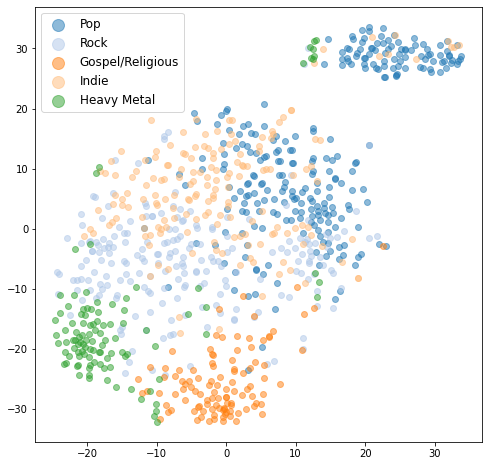

In [ ]:
classifier.eval()

# we need to use forward hooks to get the outputs from intermediate layers of the model

out = None
# Define a hook function. It sets the global out variable equal to the
# output of the layer to which this hook is attached to.

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Your model layer has a register_forward_hook that does the registering for you

classifier.cma_model.proj2.register_forward_hook(get_activation('cma_model.proj2'))

# test_embeddings = torch.zeros((0, 64), dtype=torch.float32)
test_embeddings = torch.zeros((0, 128), dtype=torch.float32)
test_predictions = []
# loop over all batches in test set
for i, (X, y) in tqdm.notebook.tqdm(enumerate(testLoader)):

  specs = X[0]
  input_ids, attention_mask = X[1]
  pred = classifier(input_ids.to(device), attention_mask.to(device), specs.to(device))
  cma_embeddings = activation['cma_model.proj2']

  res = torch.argmax(pred, 1)
  targets = y.to(device)
  test_embeddings = torch.cat((test_embeddings, cma_embeddings.detach().cpu()), 0)
  test_predictions.extend(res.detach().cpu().tolist())


test_embeddings = np.array(test_embeddings)
test_predictions = np.array(test_predictions)

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 5
labels = ['Pop','Rock','Gospel/Religious','Indie','Heavy Metal']
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = labels[lab] ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
# ax.set_title('TSNE for Multimodal (concatenated) Embeddings ', 
#              fontweight ="bold")
plt.savefig('/content/drive/MyDrive/multi-modal-music-genre-classification/TSNE/tsne_CMA.png', bbox_inches='tight')
plt.show()

# Test separately

In [ ]:
# run spec only and lyric only on test data

# pretrained_cnn_model
# lyric_model - > classifier


test_predictions_spec = []
test_predictions_lyr = []
test_predictions_concat = []
target_values = []

num_correct_spec = 0
num_correct_lyr = 0
num_correct_concat = 0
total = 0

data = []

for i, (X, y) in tqdm.notebook.tqdm(enumerate(testLoader)):

  specs = X[0]
  input_ids, attention_mask = X[1]

  pred_spec = pretrained_cnn_model(specs.float().to(device))
  res_spec = torch.argmax(pred_spec, 1)

  pred_lyr = classifier(input_ids.to(device), attention_mask.to(device), specs.to(device))
  res_lyr = torch.argmax(pred_lyr, 1)


  targets = y.to(device)
  target_values.append(targets.item())
  total += targets.size(0)

  test_predictions_spec.extend(res_spec.detach().cpu().tolist())
  test_predictions_lyr.extend(res_lyr.detach().cpu().tolist())


  num_correct_spec += (res_spec.item() == targets.item())
  num_correct_lyr += (res_lyr.item() == targets.item())

  data.append(X)

print("spec only acc: ", float(num_correct_spec)/float(total)*100)
print("lyr only acc: ", float(num_correct_lyr)/float(total)*100)

print(test_predictions_spec)
print(test_predictions_lyr)
print(target_values)


# plt.figure(figsize=(10, 4))
# librosa.display.specshow(librosa.power_to_db(ps.tolist(), ref=np.max), y_axis='mel', x_axis='time')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel spectrogram ')
# plt.tight_layout()


0it [00:00, ?it/s]

spec only acc:  38.93395133256084
lyr only acc:  43.80069524913094
[4, 3, 0, 3, 4, 0, 4, 1, 1, 0, 4, 4, 3, 0, 0, 3, 0, 0, 3, 4, 0, 0, 1, 0, 4, 0, 3, 0, 1, 0, 0, 3, 0, 0, 0, 4, 3, 1, 0, 1, 3, 3, 0, 3, 3, 0, 1, 4, 0, 0, 3, 3, 1, 1, 1, 0, 1, 0, 3, 4, 4, 3, 1, 1, 0, 0, 4, 0, 3, 0, 4, 0, 3, 0, 1, 1, 4, 1, 1, 0, 1, 0, 3, 1, 3, 0, 4, 3, 0, 0, 1, 3, 0, 1, 0, 0, 0, 3, 4, 3, 0, 0, 2, 1, 0, 1, 4, 0, 0, 3, 4, 0, 1, 0, 4, 0, 0, 4, 1, 1, 0, 0, 1, 1, 4, 0, 1, 1, 1, 1, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 1, 1, 0, 0, 4, 0, 0, 1, 3, 1, 0, 0, 3, 0, 1, 0, 1, 1, 4, 1, 0, 4, 3, 0, 4, 0, 0, 3, 1, 0, 3, 0, 1, 4, 1, 4, 1, 1, 1, 1, 0, 3, 0, 1, 0, 1, 1, 3, 0, 1, 0, 0, 0, 3, 3, 1, 0, 1, 0, 3, 0, 3, 0, 4, 3, 3, 0, 0, 1, 4, 1, 3, 0, 3, 1, 1, 1, 0, 3, 0, 1, 1, 1, 1, 3, 1, 1, 3, 0, 1, 3, 3, 1, 0, 4, 3, 1, 0, 0, 0, 0, 0, 3, 1, 0, 3, 1, 3, 3, 0, 3, 1, 0, 3, 0, 3, 0, 0, 1, 3, 2, 0, 4, 0, 1, 1, 3, 4, 0, 1, 0, 3, 0, 4, 3, 1, 4, 3, 3, 0, 0, 0, 4, 4, 0, 4, 0, 3, 1, 0, 1, 4, 1, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 1, 0, 4, 1, 0, 3, 3, 0,